# NLP with Bert for SQL injections detecting

**Importing the libraries**

In [2]:
!pip install ktrain 
!pip install chardet
import numpy as np
import ktrain
from ktrain import text
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.2 MB/s eta 0:00:00
  Created wheel for ktrain: filename=ktrain-0.33.2-py3-none-any.whl size=25313840 sha256=35779518245a1807a4ff8d70fb7728f43c1f13c1b5d9799913ed3fc3074250ce
  Stored in directory: /root/.cache/pip/wheels/e3/a5/4d/055b452e87e0297d1f9656daa307b560113f2f1076613a9f86
  Created wheel for keras_bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33516 sha256=4303b5f2facf3284464dfd89d49658dced19fdce3f98762417e3569a4bc1b395
  Stored in

**Reading and displaying the dataset**

In [6]:
# Detect the encoding of the CSV file
with open('SQLiV3.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Read the CSV file into a pandas dataframe, using the detected encoding
# df = pd.read_csv('sqliv2.csv', sep=',',  encoding=result['encoding']).sample(n=250)
df = pd.read_csv('SQLiV3.csv', sep=',',  encoding=result['encoding'])

# Display the first rows of the dataframe
print(df.head(10))

                                            Sentence  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1   AND 1  =  utl_inaddr.get_host_address   (    ...      1
2   select * from users where id  =  '1' or @ @1 ...      1
3   select * from users where id  =  1 or 1#"  ( ...      1
4   select name from syscolumns where id   =     ...      1
5  select * from users where id  =  1 +$+ or 1  =...      1
6  1;  (  load_file  (  char  (  47,101,116,99,47...      1
7   select * from users where id  =  '1' or ||/1 ...      1
8   select * from users where id  =  '1' or \.<\ ...      1
9                                    ? or 1  =  1 --      1


In [7]:
df.shape

(30608, 2)

In [8]:
print("----------------------------------------------------")
df.info()
print("----------------------------------------------------")

----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30608 entries, 0 to 30607
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  30608 non-null  object
 1   Label     30608 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 478.4+ KB
----------------------------------------------------


In [9]:
df['Label'].describe()


count    30608.000000
mean         0.370491
std          0.482944
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Label, dtype: float64

**Process NaN values**

In [10]:
df['Label'].isna().sum() # Count NaN label values.


0

**the target label**

In [12]:
# Get unique values existing in the label column.

unique_label = pd.unique(df['Label'])

print(unique_label)

[1 0]


In [13]:
df[df['Label'] == 1].count() # Count how much label are 1.


Sentence    11340
Label       11340
dtype: int64

In [14]:
df[df['Label'] == 0].count() # Count how much label are 0.


Sentence    19268
Label       19268
dtype: int64

**Distribution of the label**

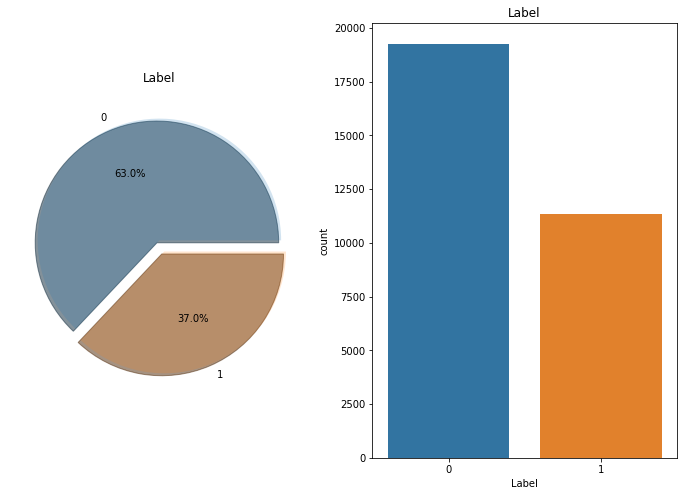

In [15]:
f,ax=plt.subplots(1,2,figsize=(12,8))
df['Label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, wedgeprops={'alpha':0.2})

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot('Label', data=df, ax=ax[1])
ax[1].set_title('Label')
plt.show()

**Creating the training and test sets**

In [16]:
sentences = df['Sentence'].tolist()
labels = df['Label'].tolist()

sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(sentences_train, labels_train, 
                                                                       preprocess_mode='bert',
                                                                       maxlen=100,
                                                                      class_names=list(set(labels_train))
                                                                      )

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


# Building the BERT model

In [17]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 100


/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


# Training the BERT model

In [18]:
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

In [19]:
learner.fit_onecycle(lr=2e-5, epochs=4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
3673/3673 [==============================] - 186s 43ms/step - loss: 0.0361 - accuracy: 0.9897 - val_loss: 0.0064 - val_accuracy: 0.9976
Epoch 2/4
3673/3673 [==============================] - 152s 41ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.0090 - val_accuracy: 0.9980
Epoch 3/4
3673/3673 [==============================] - 151s 41ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.0040 - val_accuracy: 0.9984
Epoch 4/4
3673/3673 [==============================] - 152s 41ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0041 - val_accuracy: 0.9988


In [20]:
learner.validate(class_names=preproc.get_classes())


77/77 [==============================] - 7s 27ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1491
           1       1.00      1.00      1.00       958

    accuracy                           1.00      2449
   macro avg       1.00      1.00      1.00      2449
weighted avg       1.00      1.00      1.00      2449



array([[1489,    2],
       [   1,  957]])

In [37]:
predictor = ktrain.get_predictor(learner.model, preproc)

# make a prediction on a single input text
input_text = "SELECT COUNT(*) FROM users WHERE username = 'admin'"
# sql_injections = [
#     "1'; DROP TABLE users;--",
#     "INSERT INTO users (username, password) VALUES ('testuser', 'testpassword'); DROP TABLE users;",
#     "SELECT * FROM users WHERE username = 'admin' OR 1=1;",
#     "UPDATE users SET password = 'newpassword' WHERE username = 'admin';",
#     "SELECT * FROM users WHERE username = 'admin' AND password = 'password' UNION SELECT credit_card_number, expiration_date FROM credit_cards;"
# ]
prediction = predictor.predict(input_text)
print(prediction)

1/1 [==============================] - 0s 36ms/step
1
